In [1]:
import gym
import gym_jumping_task
from gym_jumping_task.envs.jumping_task import JumpTaskEnv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
import torch.nn as nn
import augmentations
import torchvision.transforms.functional as fn
from torchvision.transforms.functional import InterpolationMode
from env import VanillaEnv

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = torch.device('cpu')

env =  VanillaEnv()

Done! Episode Reward:  24.0


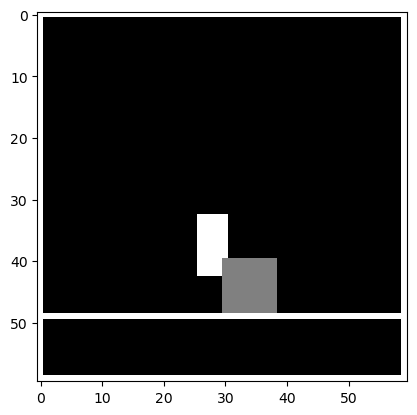

In [3]:
done = False
rewards = []
frames_arr = []

state = env.reset()
while not done:
    action = np.random.randint(low=0, high=2)
    next_state, r, done, info = env.step(action)
    rewards.append(r)
    frames_arr.append(np.expand_dims(np.flipud(state.squeeze()), axis=0))
    state = next_state
    if done: 
        print("Done! Episode Reward: ", np.sum(rewards))
        plt.imshow(np.flipud(state.squeeze()), cmap='gray', vmin=0., vmax=1.)
        break

# Augmentations

In [4]:
# convert the frames from [0., 1.] to [0, 255]
# frames = np.array(np.array(frames) * 255, dtype=np.uint8)
# Convert the frame stack into the correct format (B, C, H, W)
frames = np.array(frames_arr)
if len(frames.shape) == 3: frames = np.expand_dims(frames, axis=1)


print(frames.shape)
print(frames.dtype)
print(frames.min(), frames.max())

(26, 1, 60, 60)
float32
0.0 1.0


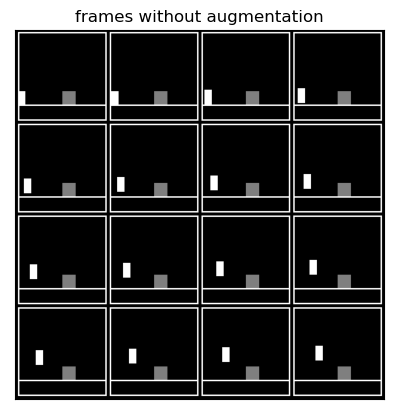

In [5]:
def show_imgs(x, max_display=16, title:str = ""):
    grid = make_grid(torch.from_numpy(x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(grid)
    if len(title) > 0: plt.title(title)
    plt.show()

show_imgs(frames, title="frames without augmentation")

(26, 1, 70, 70)


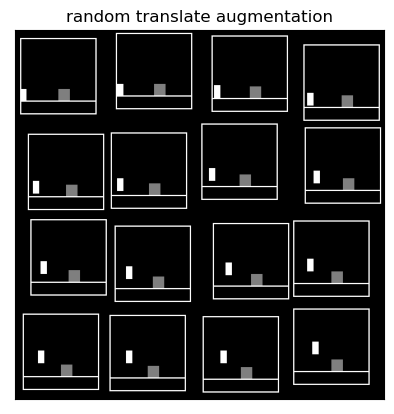

In [6]:
rnd_trans = augmentations.random_translate(frames,70)
print(rnd_trans.shape)
show_imgs(rnd_trans, title="random translate augmentation")

(26, 1, 60, 60)


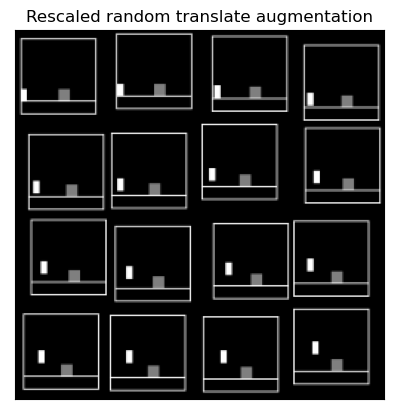

In [7]:
# Try to rescale images to 60x60
rnd_trans = fn.resize(torch.from_numpy(rnd_trans), size=[60,60]).numpy()
print(rnd_trans.shape)
show_imgs(rnd_trans, title="Rescaled random translate augmentation")

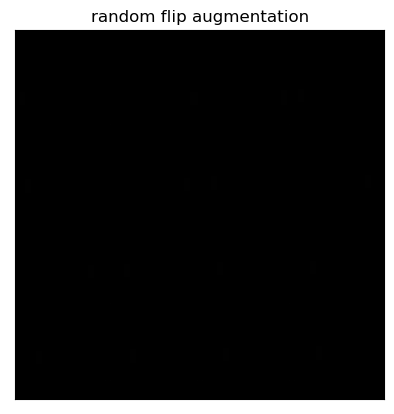

In [8]:
flipped_x = augmentations.random_flip(frames)
show_imgs(flipped_x, title="random flip augmentation")

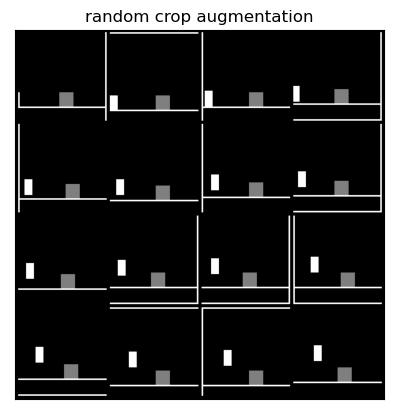

In [9]:
cropped_x = augmentations.random_crop(frames,56)
show_imgs(cropped_x, title="random crop augmentation")

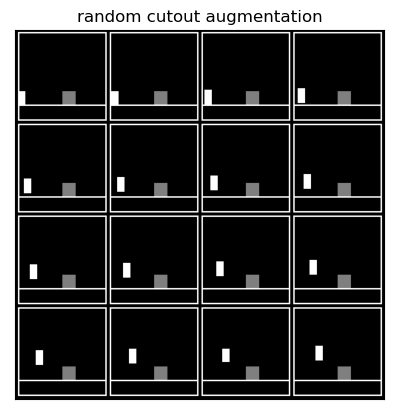

In [10]:
cut_x = augmentations.random_cutout(frames,10,15)
show_imgs(cut_x, title="random cutout augmentation")

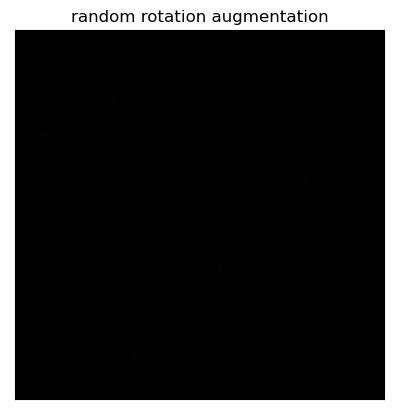

In [11]:
rnd_rotation = augmentations.random_rotation(frames,device)
show_imgs(rnd_rotation, title="random rotation augmentation")

================== 0 ==================
float32 0.0 1.0


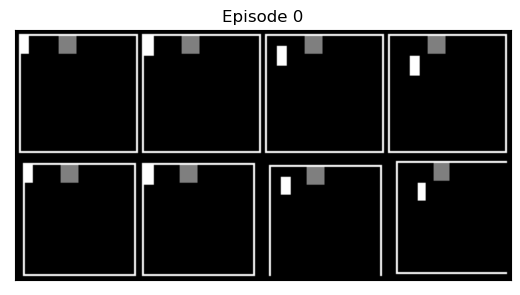

================== 1 ==================
float32 0.0 1.0


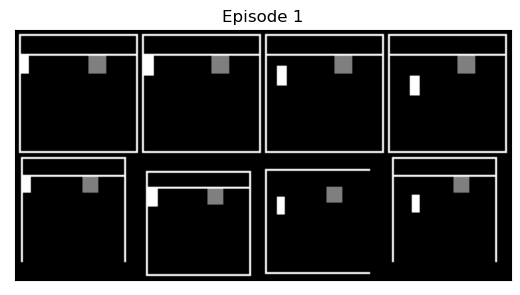

================== 2 ==================
float32 0.0 1.0


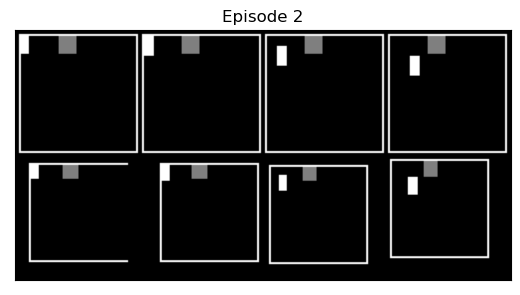

In [12]:
from env import POSSIBLE_AUGMENTATIONS, UCBAugmentingEnv

"""
UCB selects each transformation once when starting up. 
Thus if we play the first n episodes we should see all n Augmentations in action
"""

env = UCBAugmentingEnv(configurations=[(20, 0), (35, 10)])

for i in range(len(POSSIBLE_AUGMENTATIONS)):
    print(f"================== {i} ==================")
    aug_obs, ori_obs = env.reset_augmented()
    print(aug_obs.dtype, aug_obs.min(), aug_obs.max())
    aug_observations = [aug_obs, ]
    ori_observations = [ori_obs, ]

    for j in range(15):
        aug_obs, ori_obs, r, done, info = env.step_augmented(1)
        if j % 5 == 0: aug_observations.append(aug_obs)
        if j % 5 == 0: ori_observations.append(ori_obs)
    
    
    frames = np.array(ori_observations+aug_observations)
    
    # Convert the frame stack into the correct format (B, C, H, W)
    if len(frames.shape) == 3: frames = np.expand_dims(frames, axis=1)
    
    show_imgs(frames, title=f"Episode {i}", max_display=8)
    